# Midterm solutions

1. **Compute two spectra**. For this problem set, please generate a 10,000 element data set with Gaussian white noise. Use your white noise to generate a second data set using an autoregressive (AR1) process. In Matlab you can do this as follows:

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import detrend
from scipy.stats.distributions import chi2

In [3]:
# number of point
N = 10000
# generate random numbers with normal dist. (Gaussian white noise)
np.random.seed(0) # this is just to make sure everyone gets the same set of random numbers
white = np.random.randn(N)
# build red noise (here the time series will have a "memory")
auto = np.empty_like(white)
auto[0] = white[0]
for i in range(1,N):
    auto[i] = 0.5*auto[i-1] + white[i] 

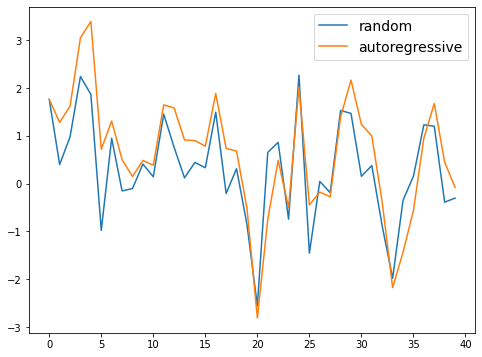

In [4]:
plt.figure(figsize=(8,6))
plt.plot(white[:40], label='random')
plt.plot(auto[:40], label='autoregressive')
plt.legend(fontsize=14)

Now compute spectra for the white noise and autoregressive data sets by breaking the data up into segments. (You can do this by reshaping your data vector as a 500×20 matrix, which will give you 20 segments, each 500 points long.) What are the differences between the spectra?

Because you will likely have to do this many times during grad school and after, I recomment writing a function to make segments.

In [5]:
def overlapping_segments(x, segment_length, overlap=0.0):
    """Divides array into overlapping segments
    Parameters
    ----------
    x : 
        input 1D array
    segment_length :
        length of each segment
    overlap : float, optional
        fraction of overlapping between segments. The default overlap is zero.
    Returns
    -------
    segments :
        ndarray with number of segments as the first dimension and segment length in the
        second dimension.
    Notes
    -----
    For this function to work segment_length times overlap has to be an integer. 
    The length of the input array len(x) divided by segment_length also has to be an integer.
    """
    
    assert isinstance(x, np.ndarray), "x must be a Numpy array"
    assert x.ndim == 1, "x must be a 1D Numpy array"
    
    N = len(x) 
    assert (N/segment_length).is_integer(), "The number of segments must be an integer"
    assert (overlap*segment_length).is_integer(), "The number of points to overlap must be an integer"
    
    n_seg = N//segment_length    
    left = range(0, N-segment_length+1, round((1-overlap)*segment_length))
    segments = []
    for l in left:
        r = l + segment_length
        segments.append(x[l:r])
    segments = np.array(segments)
    return segments

In [6]:
p = 500
white_segments = overlapping_segments(white, segment_length=p, overlap=0.0)
auto_segments = overlapping_segments(auto, segment_length=p, overlap=0.0)

In [29]:
M = white_segments.shape[0] # number of segments
print(white_segments.shape)
print(auto_segments.shape)

(20, 500)
(20, 500)


In [8]:
fft_white = np.fft.fft(detrend(white_segments, axis=-1), axis=1)
amp_white = abs(fft_white[:, :p//2+1]/p)**2 # we only get the positive frequencies (half the energy)
amp_white[:,1:-1] = 2*amp_white[:, 1:-1] # and now we multiply by two to put the energy back (not considering the mean)

We can check Parserval:

In [9]:
print(detrend(white_segments, axis=-1).var()) # variance in physical space
print(amp_white.sum()/20) # sum of squared amps divided by the number of segments

0.9716295194651154
0.9716295194651157


Now, we do the same for the red spectra

In [10]:
fft_auto = np.fft.fft(detrend(auto_segments, axis=-1), axis=1)
amp_auto = abs(fft_auto[:, :p//2+1]/p)**2 # we only get the positive frequencies (half the energy)
amp_auto[:,1:-1] = 2*amp_auto[:, 1:-1] # and now we multiply by two to put the energy back (not considering the mean)

print(detrend(auto_segments, axis=-1).var()) # variance in physical space
print(amp_auto.sum()/20) # sum of squared amps divided by the number of segments

1.288693019517679
1.2886930195176791


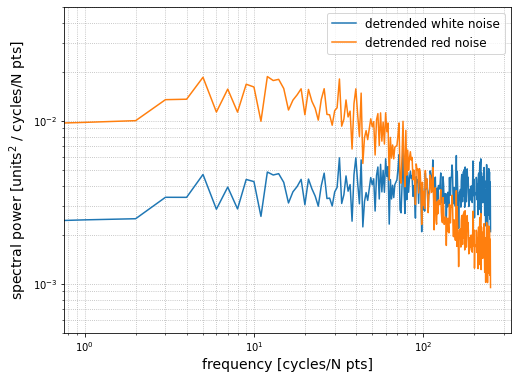

In [28]:
plt.figure(figsize=(8,6))
plt.loglog(np.arange(p//2+1),np.mean(amp_white, axis=0), label='detrended white noise')
plt.loglog(np.arange(p//2+1),np.mean(amp_auto, axis=0), label='detrended red noise')
plt.ylim([5e-4, 5e-2])         
plt.xlabel('frequency [cycles/N pts]', fontsize=14)
plt.ylabel('spectral power [units$^2$ / cycles/N pts]',fontsize=14)
plt.legend(fontsize=12)
plt.grid(which='both', ls='dotted')

If you’ve been paying attention to normalization questions, you might wonder about the y-axis label. This is noise, and we didn’t assign units, so as a placeholder I’ve inserted ‘units’. The per frequency comes with the assumption that the duration of our record (T) is N pts, so that T/N = 1.


2. **Add error bars to your spectra**. Use the χ2 formulation to compute uncertain- ties for your spectra, and show this on your plot. We compute error bars using the standard formulation:

In [31]:
nu = 2*M # nu equals twice the number of segments
error_high = nu/chi2.ppf(0.05/2, df=nu)
error_low = nu/chi2.ppf(1-0.05/2, df=nu)

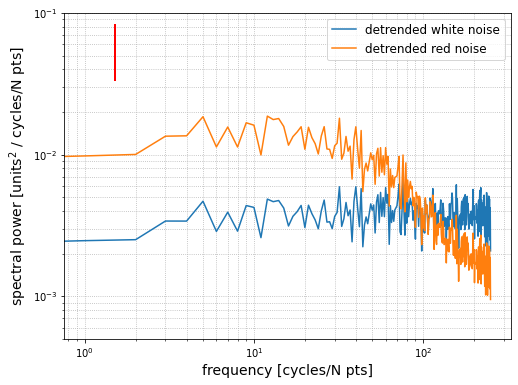

In [43]:
factor = 5e-2
plt.figure(figsize=(8,6))
plt.loglog(np.arange(p//2+1),np.mean(amp_white, axis=0), label='detrended white noise')
plt.loglog(np.arange(p//2+1),np.mean(amp_auto, axis=0), label='detrended red noise')
plt.loglog([1.5, 1.5], np.array([error_low, error_high])*factor, color='r', lw=2)
plt.ylim([5e-4, 1e-1])         
plt.xlabel('frequency [cycles/N pts]', fontsize=14)
plt.ylabel('spectral power [units$^2$ / cycles/N pts]',fontsize=14)
plt.legend(fontsize=12)
plt.grid(which='both', ls='dotted')

3. **For the white noise case, use Monte Carlo simulation to verify the $\chi^2$ error bar**. To check the error bars, you’ll want to generate multiple ensembles of data and compute spectra for each of them. I would suggest using 200 matrices that are 500×20 elements each. Compute spectra for each of them. This will provide you with 200 independent realizations of the spectrum, and you can use these 200 values to study the range of possible spectra that you could obtain from white noise. Examine the pdf of your 200 values. (Because the statistics of at Gaussian white noise are the same at all frequencies, you can merge all the frequencies to produce a larger ensemble.) Is the pdf consistent with your expectations for a variable with a χ2 distribution? 


Now, for each frequency, sort the 200 realizations of the pdf by size (e.g. using the “sort” command in Matlab. Since you are looking for the 95% confidence range, you’ll want to find the limits that exclude the lowest 2.5% and the highest 2.5% of your data—presumably the 6th and 195th points in each sorted set of pdfs.) What is the ratio of the upper limit to the lower limit? Are the error bars derived using the Monte Carlo process consistent with those from question 1? To get an idea of how representative our initial results are, we replicate this process with 200 data sets of the same size as our original data. This can be computationally intensive, but conceptually it’s fairly straightforward:

In [48]:
nr = 200 # number of realizations
N = 10000 
p = 500
ensemble = np.zeros([nr, p//2+1])
for i in range(nr):
    white = np.random.randn(N)
    white_segments = overlapping_segments(white, segment_length=p, overlap=0.0)
    fft_white = np.fft.fft(detrend(white_segments, axis=-1), axis=1)
    amp_white = abs(fft_white[:, :p//2+1]/p)**2 
    amp_white[:,1:-1] = 2*amp_white[:, 1:-1]
    ensemble[i] = np.mean(amp_white, axis=0)

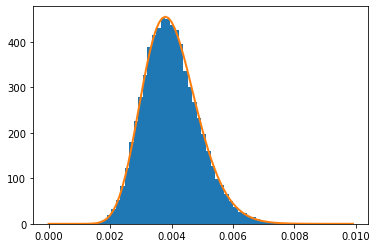

In [94]:
# We want to neglect the amplitudes at the mean and the Nyquest frequencies
all_amplitudes = ensemble[:,1:-1].flatten()
amp_range = np.linspace(all_amplitudes.min(), all_amplitudes.max(), 100)
histogram = plt.hist(all_amplitudes, 50, density=True)
plt.plot(np.arange(0,100)/1e4, chi2.pdf(np.arange(0,100), 2*M)*1e4, lw=2)

For the error bars, we want to identify the tails of the distributions. To do this, we sort the values to get an error estimate as a function of frequency:


In [101]:
upper = np.percentile(ensemble[:,1:-1], 97.5, axis=0)
lower = np.percentile(ensemble[:,1:-1], 2.5, axis=0)

This shows that the $\chi^2$ error estimate that we use for spectra is consistent with the uncertainty from random white. (You do need to ignore the first and last values, which effectively have half as many degrees of freedom.) We can also compute the mean across all frequencies:

In [109]:
print('Monte Carlo:', np.mean(upper/lower))
print('Theoretical:', error_high/error_low)

Monte Carlo: 2.3863881885337026
Theoretical: 2.4287484961785464


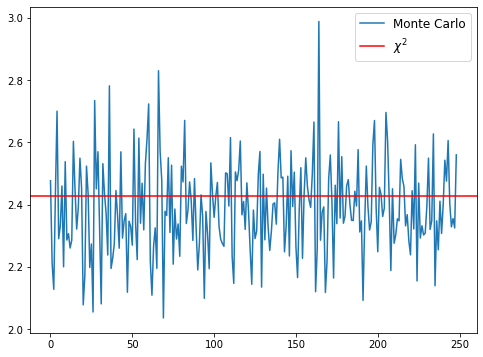

In [110]:
plt.figure(figsize=(8, 6))
plt.plot(upper/lower, label='Monte Carlo')
plt.axhline(y=error_high/error_low, color='r', label='$\chi^2$')
plt.legend(fontsize=12)

The white noise should be the same for all frequencies, so we could also have compute the percentile of all values together:

In [112]:
print(np.percentile(all_amplitudes, 97.5)/np.percentile(all_amplitudes, 2.5))

2.4427856290171586


4. **Spectra with data**. Now using your spectral methodology, compute a spectrum (with error bars) for the SIO pier pressure data from 2019 that you used in last week’s problem set. Follow best practices that we’ve discussed in class. Are you able to resolve the same peaks in your spectrum that you saw through the least- squares fit and simple Fourier transform last week?
Again we read the data and extract the appropriate segment of the record:

In [124]:
import xarray as xr
import datetime
sccoos_thredds = 'http://sccoos.org/thredds/dodsC/autoss/scripps_pier-2019.nc'
ds = xr.open_dataset(sccoos_thredds)

In [152]:
ind0 = 102826
npoints = ind0 + 10000
pressure_good = ds.pressure[ind0:npoints]
N = pressure_good.shape[0]
print(pressure_good.shape)

(10000,)


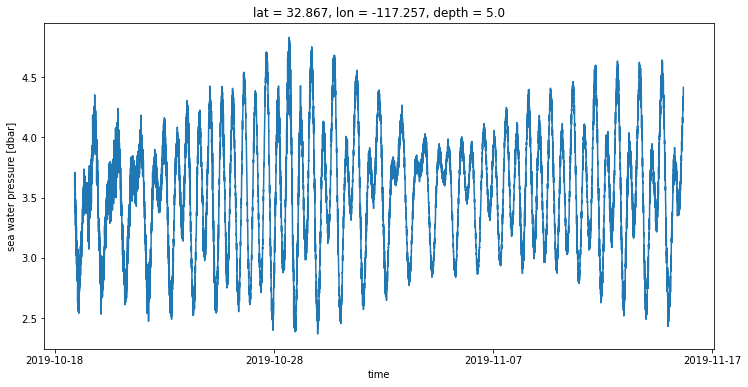

In [144]:
plt.figure(figsize=(12,6))
pressure_good.plot()

In [145]:
time_good = pressure_good.time
np.diff(time_good)

array([datetime.timedelta(seconds=240), datetime.timedelta(seconds=240),
       datetime.timedelta(seconds=240), ...,
       datetime.timedelta(seconds=240), datetime.timedelta(seconds=240),
       datetime.timedelta(seconds=240)], dtype=object)

In [146]:
(np.diff(time_good) == datetime.timedelta(seconds=240)).all()

True

In [147]:
dt = np.diff(time_good)[0].seconds

In [151]:
p = 2000
pressure_segments = overlapping_segments(pressure_good.values, segment_length=p, overlap=0.5)
M = pressure_segments.shape[0]
print(pressure_segments.shape)

(9, 2000)


In [157]:
win = np.hanning(p)*np.ones([M, p])*np.sqrt(8/3)

In [158]:
fft_pressure = np.fft.fft(detrend(pressure_segments, axis=-1)*win, axis=1)
amp_pressure = abs(fft_pressure[:, :p//2+1]/p)**2 # we only get the positive frequencies (half the energy)
amp_pressure[:,1:-1] = 2*amp_pressure[:, 1:-1] # and now we multiply by two to put the energy back (not considering the mean)

In [164]:
dt_days = 240 / (24 * 60 * 60)
freq = np.fft.rfftfreq(p, d=dt_days)

Text(0, 0.5, 'spectral power [dbar$^2$/cycles/day]')

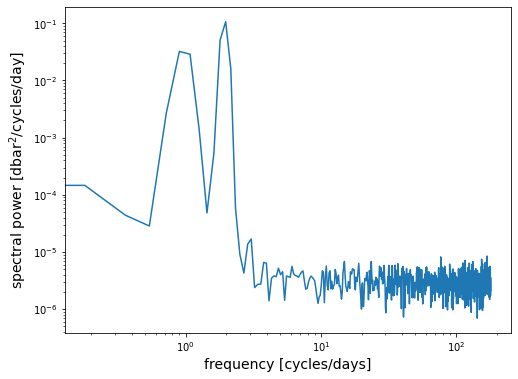

In [169]:
plt.figure(figsize=(8,6))
plt.loglog(freq, amp_pressure.mean(axis=0))
plt.xlabel('frequency [cycles/days]', fontsize=14)
plt.ylabel('spectral power [dbar$^2$/cycles/day]',fontsize=14)

One of the surprises with this data record is that it is white at high frequencies, but nonetheless, we clearly see the diurnal and semi-diurnal peaks. They are not well resolved because our frequency resolution is not terribly large, given the brevity of the record analyzed here. Now we need to add error bars:

In [170]:
nu = M*1.9 # use 1.9 for Hanning window
error_high = nu/chi2.ppf(0.05/2, df=nu)
error_low = nu/chi2.ppf(1-0.05/2, df=nu)

Text(0, 0.5, 'spectral power [dbar$^2$/cycles/day]')

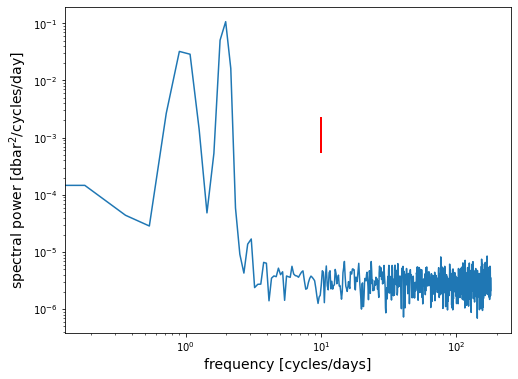

In [171]:
factor = 1e-3
plt.figure(figsize=(8,6))
plt.loglog(freq, amp_pressure.mean(axis=0))
plt.loglog([10, 10], np.array([error_low, error_high])*factor, color='r', lw=2)
plt.xlabel('frequency [cycles/days]', fontsize=14)
plt.ylabel('spectral power [dbar$^2$/cycles/day]',fontsize=14)